## Lab 3: SVM

In [14]:
import os
import mne
import numpy as np
from mne import create_info
from mne.io import RawArray
import torch
from sklearn.preprocessing import StandardScaler

data_path = "D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data"

os.makedirs(data_path, exist_ok=True)

mne.set_config('MNE_DATA', data_path, set_env=True)

mne.set_config('MNE_DATASETS_BRAININVADERS2013_PATH', data_path, set_env=True)

print(mne.get_config())

{'MNE_DATA': 'D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data', 'MNE_DATASETS_BRAININVADERS2013_PATH': 'D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data'}


In [15]:
import moabb
import warnings
from moabb.datasets import BI2013a

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
moabb.set_log_level("info")

print("MNE_DATA =", mne.get_config('MNE_DATA'))
print("MNE_DATASETS_BRAININVADERS2013_PATH =", mne.get_config('MNE_DATASETS_BRAININVADERS2013_PATH'))

m_dataset = BI2013a(NonAdaptive=True, Adaptive=True, Training=True, Online=True)
m_dataset.download()
subjects = m_dataset.subject_list
print(f"Total subjects: {len(subjects)}")

MNE_DATA = D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data
MNE_DATASETS_BRAININVADERS2013_PATH = D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data
Total subjects: 24


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
from moabb.paradigms import P300
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np

paradigm = P300()

def load_data_in_chunks(subjects, chunk_size=5):
    X_chunks, labels_chunks = [], []
    
    for i in range(0, len(subjects), chunk_size):
        chunk_subjects = subjects[i:i + chunk_size]
        X_chunk, labels_chunk = [], []
        
        for subject in chunk_subjects:
            X_subj, labels_subj, _ = paradigm.get_data(m_dataset, subjects=[subject])
            # Convert to float32 immediately to save memory
            X_subj = X_subj.astype(np.float32).reshape(X_subj.shape[0], -1)
            X_chunk.append(X_subj)
            labels_chunk.extend(labels_subj)
            
        X_chunks.append(np.vstack(X_chunk))
        labels_chunks.extend(labels_chunk)
        
        # Clear temporary variables
        del X_chunk, labels_chunk
        
    return np.vstack(X_chunks), np.array(labels_chunks)

# Replace existing data loading code with:
X, labels = load_data_in_chunks(subjects)

print("Final dataset shapes:")
print("X shape:", X.shape)
print("Labels shape:", labels.shape)
print("Labels unique values:", np.unique(labels))

label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
y = np.array([label_mapping[label] for label in labels], dtype=np.int32)

# Split with validation set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 60% train, 20% val, 20% test
)

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

print("\nProcessed data shapes:")
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)
print("Unique labels in training:", torch.unique(y_train))

# Compute class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("Class weights:", class_weights)

Final dataset shapes:
X shape: (104208, 8208)
Labels shape: (104208,)
Labels unique values: ['NonTarget' 'Target']

Processed data shapes:
Training data shape: torch.Size([62524, 8208])
Validation data shape: torch.Size([20842, 8208])
Test data shape: torch.Size([20842, 8208])
Unique labels in training: tensor([0., 1.])
Class weights: tensor([0.6000, 3.0002])


In [19]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, device=None):
        """Initialize SVM with hyperparameters."""
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.losses = []  # Store training losses
        self.val_losses = []  # Store validation losses (if provided)

    def fit(self, X, y, batch_size=64, class_weights=None, X_val=None, y_val=None, early_stopping_patience=50):
        """Fit SVM using mini-batch SGD with optional class weights and early stopping."""
        X = X.to(self.device)
        y = y.to(self.device)
        n_samples, n_features = X.shape
        self.w = torch.zeros(n_features, dtype=torch.float32, device=self.device)
        self.b = torch.tensor(0.0, dtype=torch.float32, device=self.device)

        y_ = torch.where(y <= 0, -1, 1)  # Convert labels to -1, 1 for hinge loss
        if class_weights is not None:
            class_weights = class_weights.to(self.device)
            sample_weights = torch.zeros_like(y_)
            sample_weights[y == 0] = class_weights[0]
            sample_weights[y == 1] = class_weights[1]

        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.n_iters):
            # Mini-batch
            indices = torch.randint(0, n_samples, (min(batch_size, n_samples),), device=self.device)
            X_batch = X[indices]
            y_batch = y_[indices]

            linear_pred = torch.mm(X_batch, self.w.unsqueeze(1)).squeeze() + self.b

            # Hinge loss with L2 regularization
            hinge = torch.clamp(1 - y_batch * linear_pred, min=0)
            if class_weights is not None:
                batch_weights = sample_weights[indices]
                hinge = hinge * batch_weights
            reg = 0.5 * torch.sum(self.w ** 2)  # Correct L2 regularization
            loss = torch.mean(hinge) + self.lambda_param * reg
            self.losses.append(loss.item())

            # Gradient updates
            mask = (y_batch * linear_pred <= 1).float()
            if class_weights is not None:
                weighted_mask = mask * batch_weights
                dw_hinge = torch.mm(X_batch.T, (weighted_mask * y_batch).unsqueeze(1)).squeeze()
            else:
                dw_hinge = torch.mm(X_batch.T, (mask * y_batch).unsqueeze(1)).squeeze()
            dw = self.lr * (1 / len(X_batch)) * dw_hinge - self.lr * self.lambda_param * self.w  # Correct gradient
            db = self.lr * (1 / len(X_batch)) * torch.sum(mask * y_batch) if class_weights is None else \
                 self.lr * (1 / len(X_batch)) * torch.sum(weighted_mask * y_batch)

            self.w += dw
            self.b += db

            # Validation loss for early stopping
            if X_val is not None and y_val is not None:
                with torch.no_grad():
                    X_val = X_val.to(self.device)
                    y_val_ = torch.where(y_val.to(self.device) <= 0, -1, 1)
                    val_pred = torch.mm(X_val, self.w.unsqueeze(1)).squeeze() + self.b
                    val_hinge = torch.clamp(1 - y_val_ * val_pred, min=0)
                    val_loss = torch.mean(val_hinge) + self.lambda_param * 0.5 * torch.sum(self.w ** 2)
                    self.val_losses.append(val_loss.item())
                    if val_loss < best_loss:
                        best_loss = val_loss
                        patience_counter = 0
                    else:
                        patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print(f"Early stopping at epoch {epoch}")
                        break

    def predict(self, X):
        """Predict class labels (-1 or 1, mapped to 0 or 1)."""
        X = X.to(self.device)
        linear_pred = torch.mm(X, self.w.unsqueeze(1)).squeeze() + self.b
        return torch.where(torch.sign(linear_pred) >= 0, 1, 0)  # Map -1,1 to 0,1

    def decision_function(self, X):
        """Return decision scores (wx + b) for ROC-AUC."""
        X = X.to(self.device)
        return torch.mm(X, self.w.unsqueeze(1)).squeeze() + self.b

In [20]:
svm = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=1000, device=device)
svm.fit(X_train, y_train, batch_size=64)

Early stopping at epoch 175
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.55      0.69     17368
         1.0       0.26      0.81      0.40      3474

    accuracy                           0.59     20842
   macro avg       0.60      0.68      0.54     20842
weighted avg       0.82      0.59      0.64     20842

ROC-AUC Score: 0.759898281688251


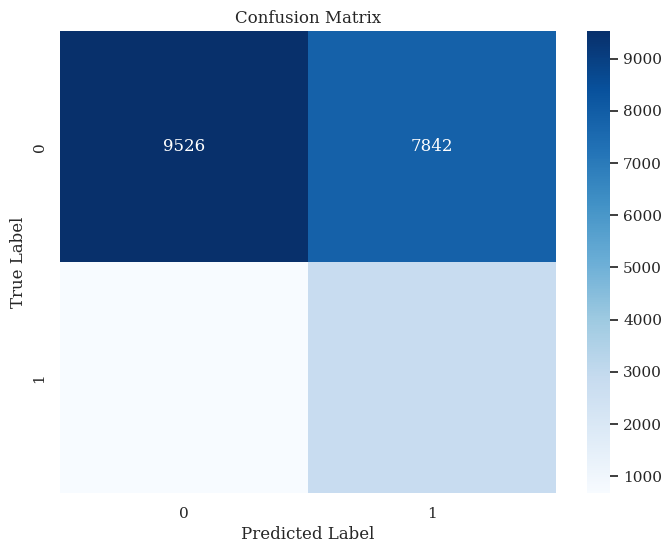

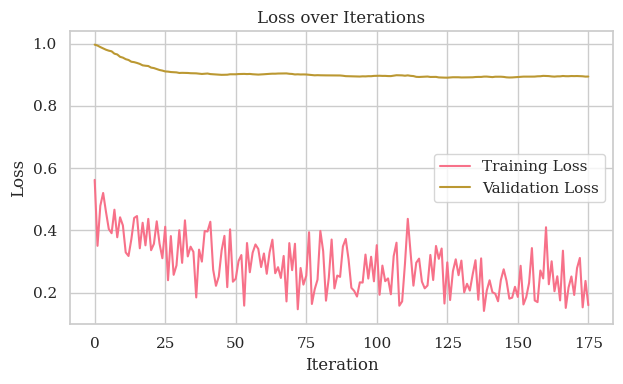

In [21]:
# Training
svm = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=1000, device=device)
svm.fit(X_train, y_train, batch_size=256, class_weights=class_weights, X_val=X_val, y_val=y_val)

# Evaluation
y_pred = svm.predict(X_test)
scores = svm.decision_function(X_test)
print("Classification Report:")
print(classification_report(y_test.numpy(), y_pred.numpy()))
print("ROC-AUC Score:", roc_auc_score(y_test.numpy(), scores.cpu().numpy()))

# Confusion Matrix
cm = confusion_matrix(y_test.numpy(), y_pred.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot Losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(svm.losses, label='Training Loss')
if svm.val_losses:
    plt.plot(svm.val_losses, label='Validation Loss')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()